Comments:

- Feature engineer the temporal data (patient_nbr and encounter_id) to keep temporal information in the data (which we'll later use for LSTM NN model.
- Make plots readable
- Perform some inputation with clustering or bucketing for missing values
- Reorganaize the sections to have clearly defined Data Cleaning, Feaature Engineering, Feature selection, Normalization, etc.
- Check whether it makes sense to do a LASSO regularizataion on the Logistic Regression to sleect features and then stick with the selected features for other models too (I am pretty sure it does not make 100% sense)
- Implement SHAP for feature selection (might need to be working jointly with models.ipynb)


Importing Libraries


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Data Transformation and Exploration.


This assignment asks you to predict readmission for diabetic patients admitted to hospital, i.e., what is the likelihood that a patient will need to come back to hospital given the data about this visit. 
This is based on a database of 101766 hospital visits with a set of 50 features covering patient information, treatment and prescribed medication during the hospital stay.
The database covers patients admitted to 130 hospitals in the US over a period of 10 years to 2008. The original data came from this source:

We decided to drop the following variables:

    'encounter_id',(TO KEEP for temporal information!)
    'patient_nbr', (TO KEEP for temporal information!)
    'payer_code',
    'medical_specialty',
    'weight',
    
For the time being, we remove the 2% missing values for "race" (which we could later inpute using clustering tecniques)

Intuitively, we can assume that all these datapoints have no incidence on the readmission because they are either abstract values arbitrarily set by humans (e.g. patinet_nbr) OR not directly related to the outcome of "readmission (e.g. "admission_source_id").

    We have decided to keep 1)'admission_type_id' and 2)'discharge_disposition_id' though they could have been droped because 
    
    1) We assume that different hospitals are exhibiting different levels of healthcare services (some better than others) 
    
    2) We assume that being sent back home can exhibit higher chances of readmission than being transfered to another hospital, in which patients are constantly monitored. 


Loading data

In [24]:
df_train = pd.read_csv("Dataset/diabetic_data_training.csv")
df_test = pd.read_csv('Dataset/diabetic_data_test.csv')

# print(df_train.head(5))
# print(df_test.head(5))

df_train.head(10)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
1,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
2,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
3,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
4,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,...,No,Steady,No,No,No,No,No,No,Yes,>30
5,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
6,63768,114882984,Caucasian,Male,[70-80),?,1,1,7,5,...,No,No,No,No,No,No,No,No,Yes,>30
7,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
8,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
9,36900,77391171,AfricanAmerican,Male,[60-70),?,2,1,4,7,...,No,Steady,No,No,No,No,No,Ch,Yes,<30


First of all, in order to know whether we should remove patient_nbr from our feeatures, which at first seens irrelevant to predicting the readmission variable, we need to check if it is repeated.
We want to check in the data whether some patients have been readmitted more than once. If so, there is a temporal dimension hidden in the data, which is important information.  

In [25]:
# check if there are some patient_id s that are repeated, meaning someone is readmitted more than once.
print(df_train['patient_nbr'].value_counts())

patient_nbr
88785891     39
88227540     23
43140906     21
1660293      20
92709351     20
             ..
24558300      1
828576        1
12294486      1
18984456      1
175429310     1
Name: count, Length: 65932, dtype: int64


Phew! That was a close call! We will keep it for now. 

We assign textual values to the numerical placeholders in the dataset communicated as we might perform some NLP

### Data Mapping and Dictionary Creation

This code performs **data mapping** (data preprocessing) by reading a CSV file (`IDS_mapping.csv`) that contains mappings of categorical or numerical IDs to their corresponding descriptions. The goal is to create a structured dictionary for each type of ID, which can later be used to translate numerical values in the main dataset into human-readable labels.

#### Key Objectives:
- **Interpretability:** Replace numerical or categorical IDs (e.g., `1`, `2`) with descriptive labels (e.g., "Emergency", "Urgent").
- **Data Enrichment:** Organize ID mappings into dictionaries for efficient lookup and transformation.
- **Data Cleaning:** Remove empty rows from the mapping CSV to ensure only relevant mappings are processed.

#### How the Code Works:
1. **Read the Mapping File:**
   - The mapping file is loaded into a Pandas DataFrame.
   
2. **Drop Empty Rows:**
   - Rows with all `NaN` values are removed to ensure clean data.

3. **Initialize Dictionary Structure:**
   - A dictionary (`dictionaries`) is created to store mappings for each category (e.g., `admission_type_id`).

4. **Iterate Over Rows:**
   - If a row starts with a numeric ID, the value is stored in the current category's dictionary.
   - If the row starts with a new category (non-numeric), the code recognizes it as a new section and initializes a new dictionary.

5. **Result:**
   - The final output is a nested dictionary where each category (like `admission_type_id`) contains mappings of IDs to their descriptive labels.


In [26]:
mapping_csv = pd.read_csv("Dataset/IDS_mapping.csv")
mapping_csv = mapping_csv.dropna(how='all')
dictionaries = {}
current_dict = 'admission_type_id'
dictionaries[current_dict] = {}


for index, row in mapping_csv.iterrows():
   id = row.to_list()[0]
   if id.isdigit():
       dictionaries[current_dict][row.to_list()[0]] = str(row.to_list()[1])
   else:
       current_dict = id
       dictionaries[current_dict] = {}

### Mapping Placeholder Values to Descriptive Labels in Train and Test Data

This code applies the previously created dictionaries to replace categorical placeholder values (`admission_type_id`, `discharge_disposition_id`, `admission_source_id`) in the training (`df_train`) and testing (`df_test`) datasets with their corresponding human-readable labels. This process enhances data interpretability and prepares the dataset for further analysis or modeling.

---

### How the Code Works:
1. **Conditional Mapping by Column Presence:**
   - The code checks if the above mentioned categorical columns exist in the DataFrame.
   - If the column is present, the `.map()` function is used to replace the placeholder values with their descriptive labels by referring to the `dictionaries` object created earlier.

2. **Mapping Process:**
   - The IDs in each column are cast to string format using `.astype(str)`, ensuring compatibility with the dictionary keys.
   - The `.map()` function performs the replacement by looking up the corresponding value from the appropriate dictionary (e.g., `dictionaries['admission_type_id']`).

---

### Why This is Important:
- **Improves Interpretability:**
   - The numeric or categorical IDs in the dataset are difficult to interpret directly. By mapping them to descriptive labels, the dataset becomes more readable and helps in exploratory data analysis and model interpretation.
- **Prevents Errors:**
   - By conditionally applying the mapping, we avoid errors that could occur if a column is missing from the DataFrame.
- **Facilitates Visualization and Reporting:**
   - Descriptive labels make charts, graphs, and summaries easier to understand and present to stakeholders.

In [27]:
# Mapping the textual values associated with teh placeholder values given originally in teh dataset

# TRAIN DATA

if 'admission_type_id' in df_train.columns:
   df_train['admission_type_id'] = df_train['admission_type_id'].astype(str).map(dictionaries['admission_type_id'])


# Map discharge dispositions
if 'discharge_disposition_id' in df_train.columns:
   df_train['discharge_disposition_id'] = df_train['discharge_disposition_id'].astype(str).map(dictionaries['discharge_disposition_id'])


if 'admission_source_id' in df_train.columns:
   df_train['admission_source_id'] = df_train['admission_source_id'].astype(str).map(dictionaries['admission_source_id'])
   
# TEST DATA

if 'admission_type_id' in df_test.columns:
   df_test['admission_type_id'] = df_test['admission_type_id'].astype(str).map(dictionaries['admission_type_id'])


# Map discharge dispositions
if 'discharge_disposition_id' in df_test.columns:
   df_test['discharge_disposition_id'] = df_test['discharge_disposition_id'].astype(str).map(dictionaries['discharge_disposition_id'])


if 'admission_source_id' in df_test.columns:
   df_test['admission_source_id'] = df_test['admission_source_id'].astype(str).map(dictionaries['admission_source_id'])
   


df_train.head(10)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,149190,55629189,Caucasian,Female,[10-20),?,Emergency,Discharged to home,Emergency Room,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
1,64410,86047875,AfricanAmerican,Female,[20-30),?,Emergency,Discharged to home,Emergency Room,2,...,No,No,No,No,No,No,No,No,Yes,NO
2,500364,82442376,Caucasian,Male,[30-40),?,Emergency,Discharged to home,Emergency Room,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
3,16680,42519267,Caucasian,Male,[40-50),?,Emergency,Discharged to home,Emergency Room,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
4,35754,82637451,Caucasian,Male,[50-60),?,Urgent,Discharged to home,Clinic Referral,3,...,No,Steady,No,No,No,No,No,No,Yes,>30
5,55842,84259809,Caucasian,Male,[60-70),?,Elective,Discharged to home,Clinic Referral,4,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
6,63768,114882984,Caucasian,Male,[70-80),?,Emergency,Discharged to home,Emergency Room,5,...,No,No,No,No,No,No,No,No,Yes,>30
7,12522,48330783,Caucasian,Female,[80-90),?,Urgent,Discharged to home,Transfer from a hospital,13,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
8,15738,63555939,Caucasian,Female,[90-100),?,Elective,Discharged/transferred to SNF,Transfer from a hospital,12,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
9,36900,77391171,AfricanAmerican,Male,[60-70),?,Urgent,Discharged to home,Transfer from a hospital,7,...,No,Steady,No,No,No,No,No,Ch,Yes,<30


### Dropping Unnecessary Columns from Train and Test Data

Here, we do some **data cleaning** and remove specific columns from the training (`df_train`) and testing (`df_test`) datasets to streamline the data and eliminate some features that are not useful for modeling or analysis.

### Key Objectives:
- **Feature Reduction:** Drop columns that do not contribute to predictive power or model performance.
- **Focus on Relevant Features:** Remove columns that may introduce noise, redundancy, or irrelevant information.

In [28]:
# Columns to drop
features_to_drop = ['payer_code', 'medical_specialty', 'weight'] 
print(df_train.columns)

print("Number of columns in df_train before dropping:", len(df_train.columns))

# # Drop columns directly from both dataframes
df_train = df_train.drop(columns=features_to_drop, axis=1)
df_test = df_test.drop(columns=features_to_drop, axis=1)

# Print the number of columns remaining
print("Number of columns in df_train after dropping:", len(df_train.columns))

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')
Number of columns in df_train before dropping: 50
Number of columns i

### Replacing Missing Values

This code carries out more **data cleaning** and replaces all instances of the placeholder value `'?'` in the training (`df_train`) and testing (`df_test`) datasets with `NaN` (Not a Number), which is the standard representation for missing values in Pandas. 
We also replace missing or placeholder values (`None` or `'none'`) in two specific columns (`max_glu_serum` and `A1Cresult`) in the training dataset (`df_train`) with a more descriptive string:  
**"The test was not conducted on this patient"**.

---

### Key Objectives:
- **Handle Missing Data:** Convert non-standard missing value indicators (`?`) to a format (`NaN`) that can be recognized and processed by Pandas' data manipulation functions.
- **Improve Data Interpretability:** Rather than leaving ambiguous values like `'none'` or `None`, this code replaces them with a clear, descriptive label that specifies why the value is missing.
- **Standardize Missing Values:** Ensures that different forms of missing values (`None` vs `'none'`) are treated consistently.
- **Ensure Consistency:** Standardize the representation of missing values across the dataset, making it easier to apply imputation or filtering techniques.


In [29]:
# Replace '?' with NaN
df_train = df_train.replace('?', pd.NA)
df_test = df_test.replace('?', pd.NA)

df_train.head()

# Replace None or 'none' values in the specified columns with the desired text
df_train['max_glu_serum'] = df_train['max_glu_serum'].replace(
    [None, 'none'], "The test was not conducted on this patient"
)
df_train['A1Cresult'] = df_train['A1Cresult'].replace(
    [None, 'none'], "The test was not conducted on this patient"
)

# Print confirmation
print("Replacement completed for 'max_glu_serum' and 'A1Cresult'.")

Replacement completed for 'max_glu_serum' and 'A1Cresult'.


### Checking for Missing Values in the Training Data

This code checks for missing values in the `df_train` dataset and prints out only the features (columns) that contain missing data.

---

### Key Objectives:
- **Identify Missing Data:** Quickly detect which features have missing values. This will help with data quality assessment and imputation.
- **Focus on Relevant Features:** Print only the features with missing values to avoid unnecessary output and make the analysis more efficient.

In [30]:
# Checking for Missing Values and Printing Only Features with Missing Values
missing_values = df_train.isnull().sum()

# Filter for features with missing values
missing_features = missing_values[missing_values > 0]

# Print the features with missing values
print("\nFeatures with Missing Values:")
print(missing_features)


Features with Missing Values:
race      2059
diag_1      21
diag_2     320
diag_3    1266
dtype: int64


As we can see, two of our dataset features have a large number of missing values. 

These are:

max_glu_serum: Indicates the range of the result or if the test was not taken. Values: >200, >300, normal, and none if not measured.

A1Cresult: Indicates the range of the result or if the test was not taken. Values: >8 if the result was greater than 8%, >7 if the result was greater than 7% but less than 8%, normal if the result was less than 7%, and none if not measured.

The problem is that these two columns are mixing numerical values with categorical ones. COULD WE POTENTIALLY CONVERT ALL OF THESE INTO STRINGS AND EMBBED THEM? THEN ??


In [31]:
print(df_train.columns)

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')


### Converting Age from Categorical to Numerical Values

This code transforms the `age` column in the training (`df_train`) and testing (`df_test`) datasets from categorical bins into representative numerical values. This process facilitates easier analysis and allows age to be treated as a continuous variable in modeling. 

---

### Key Objectives:
- **Numerical Representation:** Convert categorical age ranges into numerical values that approximate the midpoint of each range.
- **Enable Mathematical Operations:** Transforming categorical data into numerical form allows for statistical operations, visualization, and direct input into machine learning models.

This step is part of **data transformation** and **feature engineering**.

In [32]:
# convert age from categorical to numerical variable
age_mapping = {
       '[0-10)' : 5,
       '[10-20)' : 15,
       '[20-30)' : 25,
       '[30-40)' : 35,
       '[40-50)' : 45,
       '[50-60)' : 55,
       '[60-70)' : 65,
       '[70-80)' : 75,
       '[80-90)' : 85,
       '[90-100)' : 95,
}

df_train['age'] = df_train['age'].map(age_mapping)
df_test['age'] = df_test['age'].map(age_mapping)



### One-Hot Encoding of Categorical Variables

This code performs **one-hot encoding** on the categorical features in the training (`df_train`) and testing (`df_test`) datasets. One-hot encoding transforms categorical variables into binary columns, ensuring the dataset is in a format that machine learning models can process effectively.

---

### Key Objectives:
- **Convert Categorical Data to Numerical Format:** One-hot encoding replaces each unique category with a binary column (0 or 1).
- **Prepare Data for Modeling:** Many machine learning algorithms require numerical input, and categorical data must be transformed accordingly.

This step is part of **data transformation** and **feature engineering** to prepare the dataset for machine learning.


In [33]:
# hot-one encoding of all our categorical variables. 

categorical_columns = [
    'race', 'gender', 'max_glu_serum', 'A1Cresult', 'metformin', 
    'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 
    'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 
    'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 
    'glipizide-metformin', 'glimepiride-pioglitazone', 
    'metformin-rosiglitazone', 'metformin-pioglitazone', 
    'change', 'diabetesMed', 
] # 'readmitted' if you want to have a 3-output classification instead of tradi ,multinomial

df_train_cat = pd.get_dummies(df_train[categorical_columns+ ['admission_type_id','discharge_disposition_id','admission_source_id']],drop_first=False) # we set drop_first=False because our readmission column takes three values which requires creating three columns
df_test_cat = pd.get_dummies(df_test[categorical_columns+ ['admission_type_id','discharge_disposition_id','admission_source_id']],drop_first=False) # we set drop_first=False because our readmission column takes three values which requires creating three columns


### Selecting Numerical Features from Train and Test Datasets

This code extracts numerical columns from the training (`df_train`) and testing (`df_test`) datasets to create separate DataFrames (`df_train_num` and `df_test_num`) that contain only numerical variables.

---

### Key Objectives:
- **Isolate Numerical Features:** By selecting only numerical columns, the code separates continuous or discrete variables from categorical data.
- **Prepare for Modeling:** Machine learning algorithms often process numerical data differently from categorical data. Isolating numerical features facilitates easier scaling, normalization, and modeling.

This step is part of the **feature selection** and **data preprocessing** process.

In [ ]:
# Select numerical columns for df_train
df_train_num = df_train[['patient_nbr', 'encounter_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
                         'num_medications', 'number_outpatient', 'number_emergency',
                         'number_inpatient', 'number_diagnoses', 'readmitted']]

# Select numerical columns for df_test
df_test_num = df_test[['patient_nbr', 'encounter_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
                       'num_medications', 'number_outpatient', 'number_emergency',
                       'number_inpatient', 'number_diagnoses', 'readmitted']]


# Generate Timestep for Each Patient (Visit Number)
df_train_num['timestep'] = df_train_num.groupby('patient_nbr').cumcount() + 1
df_test_num['timestep'] = df_test_num.groupby('patient_nbr').cumcount() + 1

# Create Readmission Status Columns
df_train_num['readmitted_<30'] = (df_train_num['readmitted'] == '<30').astype(int)
df_train_num['readmitted_>30'] = (df_train_num['readmitted'] == '>30').astype(int)
df_train_num['readmitted_NO'] = (df_train_num['readmitted'] == 'NO').astype(int)

df_test_num['readmitted_<30'] = (df_test_num['readmitted'] == '<30').astype(int)
df_test_num['readmitted_>30'] = (df_test_num['readmitted'] == '>30').astype(int)
df_test_num['readmitted_NO'] = (df_test_num['readmitted'] == 'NO').astype(int)

# Reorder columns to place timestep as the 3rd column train dataset
columns = list(df_train_num.columns)
columns.insert(2, columns.pop(columns.index('timestep')))
df_train_num = df_train_num[columns]

# Select Relevant Columns (Keep Timestep)
temporal_cols = [col for col in df_train_num.columns if col not in ['readmitted']]
df_train_num = df_train_num[temporal_cols]

# Reorder columns to place timestep as the 3rd column test dataset
columns = list(df_test_num.columns)
columns.insert(2, columns.pop(columns.index('timestep')))
df_test_num = df_test_num[columns]

# Select Relevant Columns (Keep Timestep)
temporal_cols = [col for col in df_test_num.columns if col not in ['readmitted']]
df_test_num = df_test_num[temporal_cols]


C:\Users\vidur\AppData\Local\Temp\ipykernel_18944\2851168251.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_num['timestep'] = df_train_num.groupby('patient_nbr').cumcount() + 1
C:\Users\vidur\AppData\Local\Temp\ipykernel_18944\2851168251.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_num['cumulative_lab_procedures'] = df_train_num.groupby('patient_nbr')['num_lab_procedures'].cumsum()
C:\Users\vidur\AppData\Local\Temp\ipykernel_18944\2851168251.py:17: SettingWithCopyWarning: 
A 

### Concatenating Numerical and Categorical Features

This code combines the numerical, categorical, and target variables from the training (`df_train`) and testing (`df_test`) datasets into unified DataFrames (`df_train_concat` and `df_test_concat`). This prepares the data for modeling by ensuring all relevant features are in a single DataFrame.

---

### Key Objectives:
- **Create Complete Datasets:** The goal is to merge different types of features—numerical, categorical (one-hot encoded), and age—along with the target variable (`readmitted`) into a consolidated dataset.
- **Ensure Model Readiness:** By concatenating all features, the resulting DataFrame can be directly fed into machine learning algorithms.

This step is part of the **data preprocessing** and **feature engineering** workflow, finalizing the dataset for model training and evaluation.

In [ ]:
# Now, we concatenate all types of variables together
df_train_concat = pd.concat([df_train_num, df_train_cat, df_train['age'], df_train["readmitted"]], axis = 1)
df_test_concat = pd.concat([df_test_num, df_test_cat, df_test['age'], df_test["readmitted"]], axis = 1)

#CAT
print(len(df_train_cat.columns))
print(len(df_test_cat.columns))


display(df_train_concat,df_test_concat)

137
119


,patient_nbr,encounter_id,timestep,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,admission_source_id_ Transfer from another health care facility,admission_source_id_ Transfer from critial access hospital,admission_source_id_ Transfer from hospital inpt/same fac reslt in a sep claim,admission_source_id_Clinic Referral,admission_source_id_HMO Referral,admission_source_id_Normal Delivery,admission_source_id_Transfer from a hospital,admission_source_id_nan,age,readmitted
0,55629189,149190,1,3,59,0,18,0,0,0,...,False,False,False,False,False,False,False,False,15,>30
1,86047875,64410,1,2,11,5,13,2,0,1,...,False,False,False,False,False,False,False,False,25,NO
2,82442376,500364,1,2,44,1,16,0,0,0,...,False,False,False,False,False,False,False,False,35,NO
3,42519267,16680,1,1,51,0,8,0,0,0,...,False,False,False,False,False,False,False,False,45,NO
4,82637451,35754,1,3,31,6,16,0,0,0,...,False,False,False,True,False,False,False,False,55,>30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91584,100162476,443847548,2,3,51,0,16,0,0,0,...,False,False,False,False,False,False,False,False,75,>30
91585,74694222,443847782,1,5,33,3,18,0,0,1,...,False,False,False,False,False,False,False,False,85,NO
91586,41088789,443854148,3,1,53,0,9,1,0,0,...,False,False,False,False,False,False,False,False,75,NO
91587,31693671,443857166,4,10,45,2,21,0,0,1,...,False,False,False,False,False,False,False,False,85,NO


,patient_nbr,encounter_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,admission_source_id_ Physician Referral,admission_source_id_ Transfer from a Skilled Nursing Facility (SNF),admission_source_id_ Transfer from another health care facility,admission_source_id_Clinic Referral,admission_source_id_HMO Referral,admission_source_id_Normal Delivery,admission_source_id_Transfer from a hospital,admission_source_id_nan,age,readmitted
0,8222157,2278392,1,41,0,1,0,0,0,1,...,True,False,False,False,False,False,False,False,5,NO
1,89869032,28236,9,47,2,17,0,0,0,9,...,False,False,False,False,False,False,False,False,45,>30
2,22864131,150006,2,66,1,19,0,0,0,7,...,False,False,False,False,False,False,True,False,55,NO
3,56480238,253380,6,87,0,18,0,0,0,9,...,False,False,False,False,False,False,False,False,65,NO
4,80588529,383430,1,28,0,15,0,0,0,4,...,False,False,False,False,False,False,False,False,75,>30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10172,180189752,443266892,5,71,5,23,0,0,0,9,...,False,False,False,False,False,False,False,False,55,>30
10173,38726739,443721236,3,57,4,11,0,0,1,9,...,False,False,False,False,False,False,False,False,75,NO
10174,134647673,443778398,1,1,5,8,0,0,0,4,...,True,False,False,False,False,False,False,False,45,NO
10175,138784172,443824292,3,31,2,24,0,0,0,9,...,True,False,False,False,False,False,False,False,85,<30


As we can see, our train and test data frames have different lengths (number of cols), this is because we have one-hot encoded everything and the values taken by certain columns were different in the train and test sets. This comes from the given test set itself, which does not contain as many different observations that the train set. When testing our model we'll have to set all columns present in the train set but not test set equal to 0 since they cannot be tested. (natral imbalance...)

### Converting Binary Categorical Values to Numerical Format

This code replaces binary categorical values (`Yes`, `No`, `True`, `False`) in the concatenated train and test datasets with numerical values (`1` and `0`).

---

### Key Objectives:
- **Standardize Binary Data:** Convert textual and boolean binary values into integers to ensure consistency and simplify data interpretation.
- **Model Compatibility:** Machine learning models require numerical input. Replacing binary strings (`Yes/No`) and booleans (`True/False`) with `1` and `0` ensures the data can be processed directly.

This step is part of **data cleaning** and **preprocessing**, ensuring that all features are numerical and ready for model training.

In [36]:
# We still have some non-numerical binary values which we need to replace by zeros and ones. For all columns in the dataset, make sure that Yes, True are replaced by 1 and that No, False are replaced by 0. 

df_train_concat = df_train_concat.replace({'Yes': 1, 'No': 0, True: 1, False: 0})
df_test_concat = df_test_concat.replace({"yes":1, "No":0, True:1, False:0})

# Save the temporal data to CSV for external use
df_train_concat.to_csv(r'C:\Users\vidur\Desktop\Temp\temporal_dataset1.csv', index=False)

display(df_train_concat.head(), df_test_concat.head())


C:\Users\vidur\AppData\Local\Temp\ipykernel_18944\755488638.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train_concat = df_train_concat.replace({'Yes': 1, 'No': 0, True: 1, False: 0})
C:\Users\vidur\AppData\Local\Temp\ipykernel_18944\755488638.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test_concat = df_test_concat.replace({"yes":1, "No":0, True:1, False:0})


,patient_nbr,encounter_id,timestep,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,admission_source_id_ Transfer from another health care facility,admission_source_id_ Transfer from critial access hospital,admission_source_id_ Transfer from hospital inpt/same fac reslt in a sep claim,admission_source_id_Clinic Referral,admission_source_id_HMO Referral,admission_source_id_Normal Delivery,admission_source_id_Transfer from a hospital,admission_source_id_nan,age,readmitted
0,55629189,149190,1,3,59,0,18,0,0,0,...,0,0,0,0,0,0,0,0,15,>30
1,86047875,64410,1,2,11,5,13,2,0,1,...,0,0,0,0,0,0,0,0,25,NO
2,82442376,500364,1,2,44,1,16,0,0,0,...,0,0,0,0,0,0,0,0,35,NO
3,42519267,16680,1,1,51,0,8,0,0,0,...,0,0,0,0,0,0,0,0,45,NO
4,82637451,35754,1,3,31,6,16,0,0,0,...,0,0,0,1,0,0,0,0,55,>30


,patient_nbr,encounter_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,admission_source_id_ Physician Referral,admission_source_id_ Transfer from a Skilled Nursing Facility (SNF),admission_source_id_ Transfer from another health care facility,admission_source_id_Clinic Referral,admission_source_id_HMO Referral,admission_source_id_Normal Delivery,admission_source_id_Transfer from a hospital,admission_source_id_nan,age,readmitted
0,8222157,2278392,1,41,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,5,NO
1,89869032,28236,9,47,2,17,0,0,0,9,...,0,0,0,0,0,0,0,0,45,>30
2,22864131,150006,2,66,1,19,0,0,0,7,...,0,0,0,0,0,0,1,0,55,NO
3,56480238,253380,6,87,0,18,0,0,0,9,...,0,0,0,0,0,0,0,0,65,NO
4,80588529,383430,1,28,0,15,0,0,0,4,...,0,0,0,0,0,0,0,0,75,>30


### Verifying Removal of Non-Numerical Values

This code checks if there are any remaining non-numerical columns in the concatenated training (`df_train_concat`) and testing (`df_test_concat`) datasets. The goal is to ensure that all features, except for the target variable, are in numerical format.

---

- **Confirm Numerical Data:** Verify that all features (except the target variable) are numerical.
- **Identify Remaining Non-Numerical Columns:** If any non-numerical columns remain, they will be listed for further transformation.

This step is part of the **data validation** and **data quality assurance** process, ensuring that the dataset is fully prepared for machine learning model development.

In [37]:
# finally, let's make sure we got rid of all non-numerical values except the target var. 
non_numerical_columns_train = df_train_concat.select_dtypes(exclude=['number']).columns.tolist()

print("Non-numerical columns:", non_numerical_columns_train)

non_numerical_columns_test = df_train_concat.select_dtypes(exclude=['number']).columns.tolist()

print("Non-numerical columns:", non_numerical_columns_test)


Non-numerical columns: ['readmitted']
Non-numerical columns: ['readmitted']


### Feature Selection and Dimensionality Reduction

This code selects the most important features from the dataset through multiple techniques, ensuring the final dataset retains only the most informative features. This process enhances model performance, reduces overfitting, and speeds up training.

---
1. **Chi-Square Test:** Identify the features that have the strongest association with the target variable (`readmitted`).
2. **Lasso Regression (L1 Penalty):** Select features by shrinking less important ones to zero, retaining only the most significant.
3. **Principal Component Analysis (PCA):** Reduce dimensionality by transforming selected features into orthogonal components that capture maximum variance.

This process is part of **feature selection** and **dimensionality reduction** to prepare datasets for machine learning pipelines.

Applying Chi-Square Test...


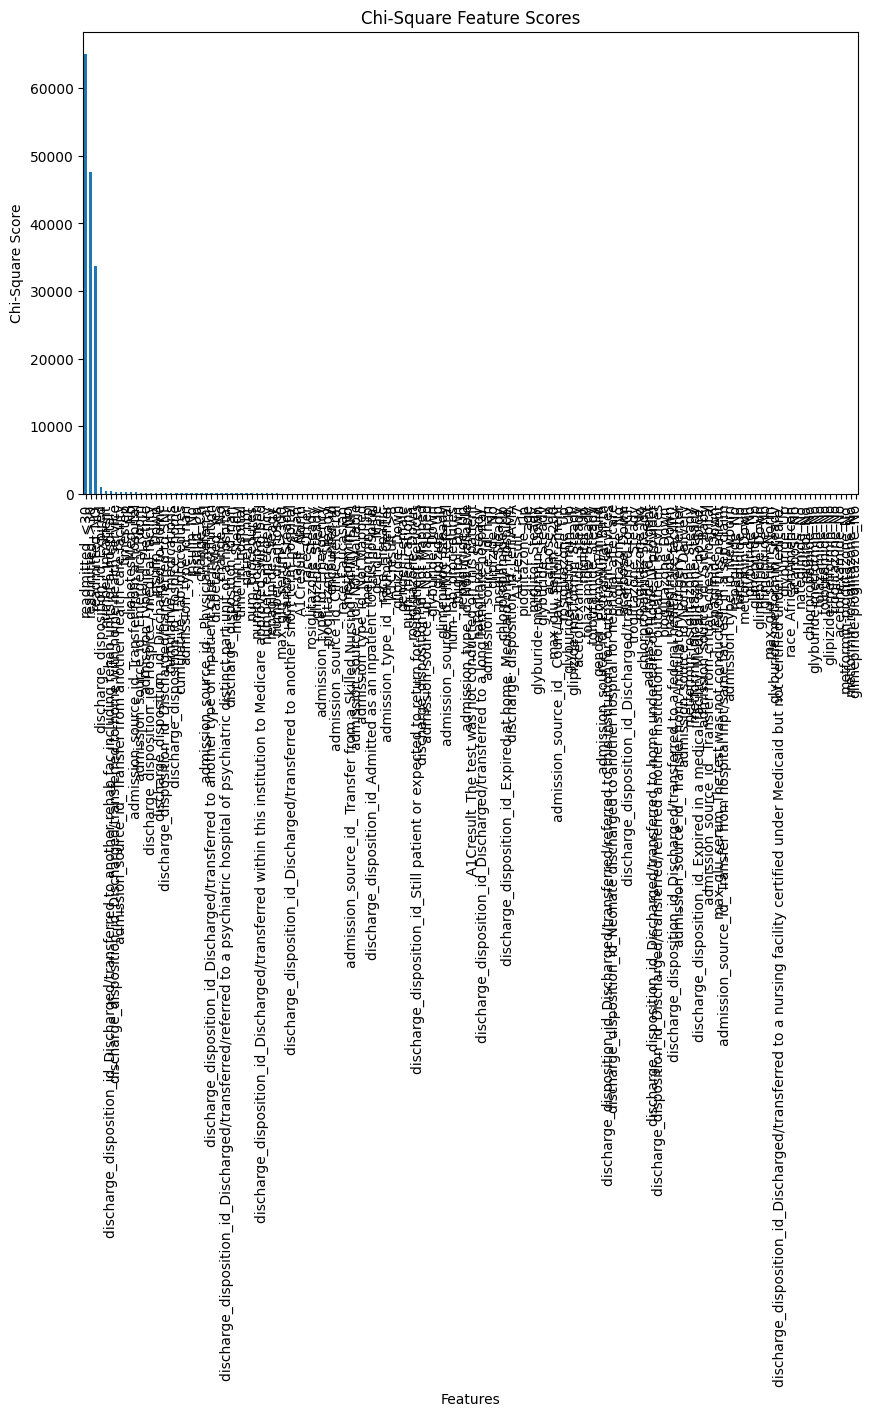

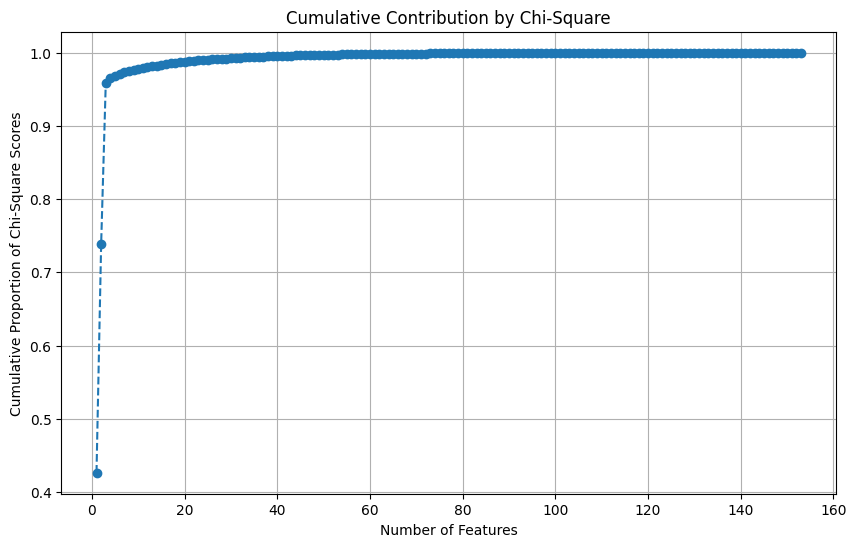

Optimal number of features to retain from Chi-Square: 25
Top 25 features selected by Chi-Square:
 ['readmitted_<30', 'readmitted_>30', 'readmitted_NO', 'discharge_disposition_id_Expired', 'number_inpatient', 'discharge_disposition_id_Discharged/transferred to another rehab fac including rehab units of a hospital .', 'discharge_disposition_id_Discharged/transferred to home with home health service', 'admission_source_id_ Transfer from another health care facility', 'timestep', 'diabetesMed_No', 'admission_source_id_Transfer from a hospital', 'admission_source_id_ Emergency Room', 'admission_type_id_Elective', 'discharge_disposition_id_Hospice / medical facility', 'insulin_Down', 'discharge_disposition_id_Discharged to home', 'discharge_disposition_id_Discharged/transferred to SNF', 'cumulative_medications', 'discharge_disposition_id_Hospice / home', 'cumulative_lab_procedures', 'admission_type_id_nan', 'insulin_No', 'insulin_Up', 'change_Ch', 'admission_source_id_ Physician Referral']
A

c:\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


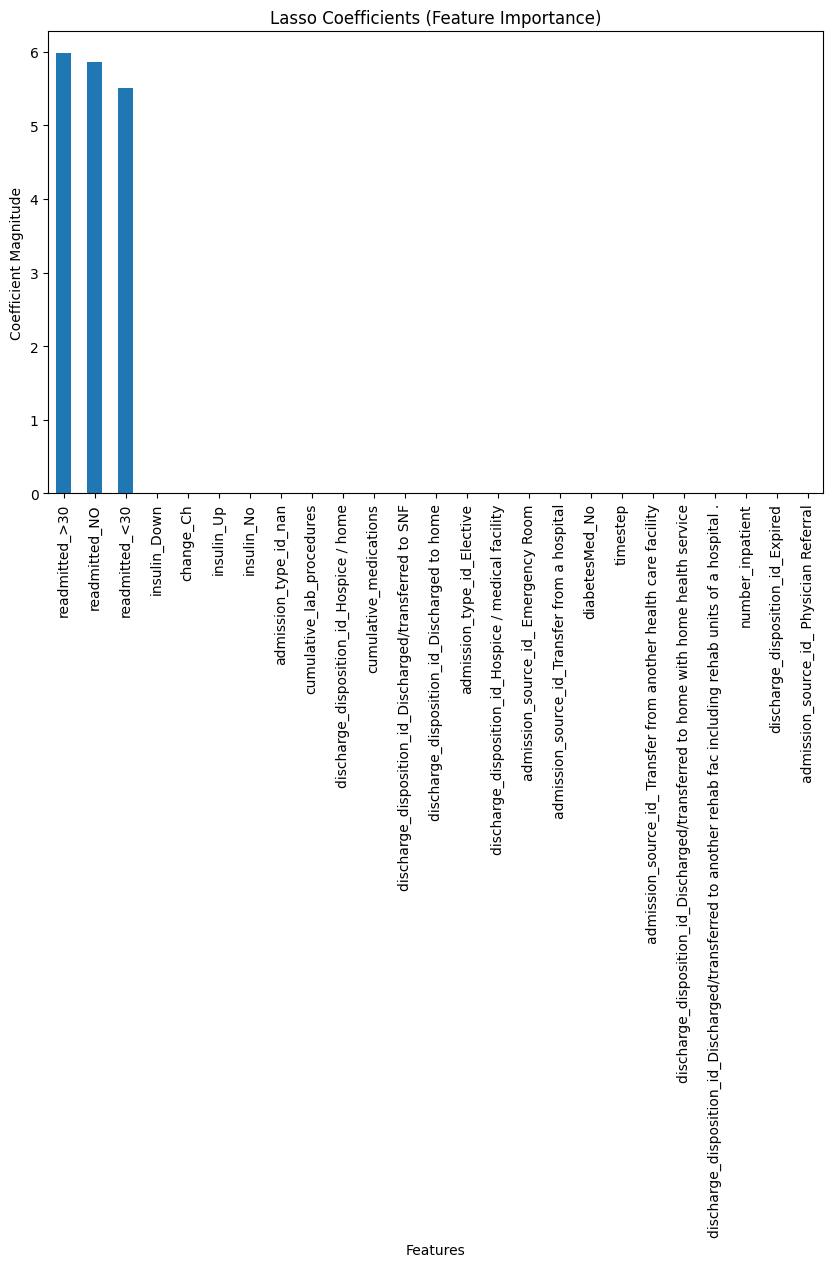

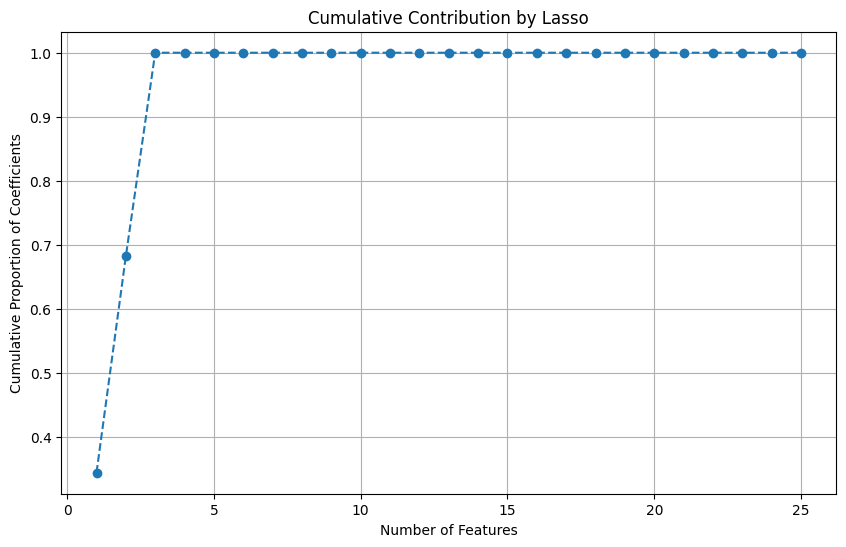

Optimal number of features to retain from Lasso: 3
Top 3 features selected by Lasso:
 ['readmitted_>30', 'readmitted_NO', 'readmitted_<30']
Applying PCA...


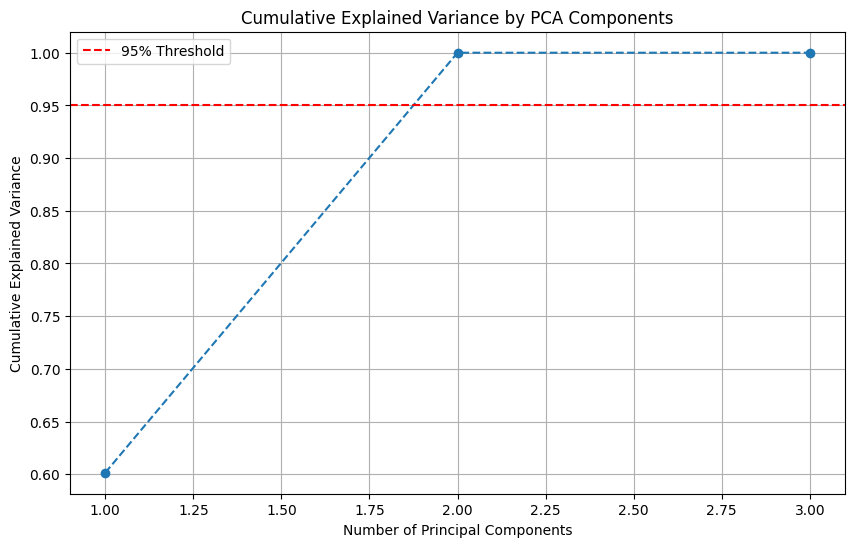

Optimal number of PCA components to retain: 2
Data ready for training:
X_train_final shape: (73271, 2)
X_test_final shape: (18318, 2)


In [38]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Step 1: Split Dataset into Features and Target
X = df_train_concat.drop(columns=['readmitted'])  # Features
y = df_train_concat['readmitted']  # Target

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Encode the Target Variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Converts categorical target to numeric

# Step 3: Min-Max Scaling for Chi-Square
minmax_scaler = MinMaxScaler()
X_train_minmax_scaled = minmax_scaler.fit_transform(X_train)
X_test_minmax_scaled = minmax_scaler.transform(X_test)

# Step 4: Chi-Square Test
print("Applying Chi-Square Test...")
chi2_selector = SelectKBest(score_func=chi2, k='all')  # Use 'all' to get scores for all features
chi2_selector.fit(X_train_minmax_scaled, y_train_encoded)

# Chi-Square scores and plot
chi2_scores = pd.Series(chi2_selector.scores_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
chi2_scores.plot(kind='bar', title="Chi-Square Feature Scores")
plt.xlabel("Features")
plt.ylabel("Chi-Square Score")
plt.show()

# Cumulative explained contribution (Chi-Square)
cumulative_scores_chi2 = np.cumsum(chi2_scores) / chi2_scores.sum()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_scores_chi2) + 1), cumulative_scores_chi2, marker='o', linestyle='--')
plt.title('Cumulative Contribution by Chi-Square')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Proportion of Chi-Square Scores')
plt.grid()
plt.show()

# Optimal number of features from Chi-Square
desired_contribution = 0.99
optimal_k_chi2 = np.argmax(cumulative_scores_chi2 >= desired_contribution) + 1
print(f"Optimal number of features to retain from Chi-Square: {optimal_k_chi2}")

top_features_chi2 = chi2_scores.head(optimal_k_chi2).index.tolist()
print(f"Top {optimal_k_chi2} features selected by Chi-Square:\n", top_features_chi2)

# Reduce dataset to Chi-Square selected features
X_train_chi2_selected = pd.DataFrame(X_train_minmax_scaled, columns=X_train.columns)[top_features_chi2]
X_test_chi2_selected = pd.DataFrame(X_test_minmax_scaled, columns=X_test.columns)[top_features_chi2]

# Step 5: Lasso Feature Selection
print("Applying Lasso for Feature Selection...")
standard_scaler = StandardScaler()
X_train_lasso_scaled = standard_scaler.fit_transform(X_train_chi2_selected)
X_test_lasso_scaled = standard_scaler.transform(X_test_chi2_selected)

lasso = LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial', max_iter=1000, random_state=42)
lasso.fit(X_train_lasso_scaled, y_train_encoded)

lasso_coefficients = pd.Series(np.abs(lasso.coef_).sum(axis=0), index=X_train_chi2_selected.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
lasso_coefficients.plot(kind='bar', title="Lasso Coefficients (Feature Importance)")
plt.xlabel("Features")
plt.ylabel("Coefficient Magnitude")
plt.show()

# Cumulative explained contribution (Lasso)
cumulative_scores_lasso = np.cumsum(lasso_coefficients) / lasso_coefficients.sum()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_scores_lasso) + 1), cumulative_scores_lasso, marker='o', linestyle='--')
plt.title('Cumulative Contribution by Lasso')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Proportion of Coefficients')
plt.grid()
plt.show()

# Optimal number of features from Lasso
optimal_k_lasso = np.argmax(cumulative_scores_lasso >= desired_contribution) + 1
print(f"Optimal number of features to retain from Lasso: {optimal_k_lasso}")

top_features_lasso = lasso_coefficients.head(optimal_k_lasso).index.tolist()
print(f"Top {optimal_k_lasso} features selected by Lasso:\n", top_features_lasso)

# Reduce dataset to Lasso selected features
X_train_lasso_selected = pd.DataFrame(X_train_lasso_scaled, columns=X_train_chi2_selected.columns)[top_features_lasso]
X_test_lasso_selected = pd.DataFrame(X_test_lasso_scaled, columns=X_test_chi2_selected.columns)[top_features_lasso]

# Step 6: PCA
print("Applying PCA...")
pca = PCA()
X_train_pca = pca.fit_transform(X_train_lasso_selected)
X_test_pca = pca.transform(X_test_lasso_selected)

explained_variance_pca = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_pca) + 1), explained_variance_pca, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.legend()
plt.grid()
plt.show()

# Optimal number of PCA components
optimal_k_pca = np.argmax(explained_variance_pca >= desired_contribution) + 1
print(f"Optimal number of PCA components to retain: {optimal_k_pca}")

# Refit PCA with optimal number of components
pca = PCA(n_components=optimal_k_pca)
X_train_final = pca.fit_transform(X_train_lasso_selected)
X_test_final = pca.transform(X_test_lasso_selected)

# Final dataset ready for training
print("Data ready for training:")
print(f"X_train_final shape: {X_train_final.shape}")
print(f"X_test_final shape: {X_test_final.shape}")

In [39]:
# import the clean data to run models in another notebook: 

import pickle

# Save the data using pickle
with open("train_test_data.pkl", "wb") as f:
    pickle.dump((X_train_final, X_test_final, y_train_encoded, y_test), f)

RUN THIS PART ONLY IF YOU INTEND TO USE AUTOML

In [40]:
y_train_encoded 

array([2, 0, 2, ..., 2, 2, 2])

In [41]:
y_test

42526     NO
24023    >30
57136    >30
55770     NO
76359     NO
        ... 
5552      NO
18997     NO
23541    >30
51491     NO
2238     >30
Name: readmitted, Length: 18318, dtype: object

In [42]:
class_mapping = {label: index for index, label in enumerate(label_encoder.classes_)}
print("Mapping of classes to encoded values:", class_mapping)


Mapping of classes to encoded values: {'<30': 0, '>30': 1, 'NO': 2}


In [43]:
# Convert y_test to a NumPy array and drop the index
y_test = y_test.reset_index(drop=True).to_numpy().ravel()  # Ensure it's 1D

# Assuming label_encoder is already fitted
y_test_encoded = label_encoder.transform(y_test)  # Encode test target variable

# Verify the class mapping
class_mapping = {label: index for index, label in enumerate(label_encoder.classes_)}
print("Mapping of classes to encoded values:", class_mapping)

# Print encoded values of y_test
print("Encoded y_test:", y_test_encoded)

Mapping of classes to encoded values: {'<30': 0, '>30': 1, 'NO': 2}
Encoded y_test: [2 1 1 ... 1 2 1]


In [44]:
# import the clean data to run models in another notebook: 

import pickle

# Save the data using pickle
with open("train_test_data.pkl", "wb") as f:
    pickle.dump((X_train_final, X_test_final, y_train_encoded, y_test_encoded), f)